**Wstępna eksploracja danych**

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message=".*failed to converge.*")

In [2]:
# biblioteki
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

np.random.seed(100)

# zbiór danych
data_CTR = pd.read_csv("ad_10000records.csv", sep=',', nrows= 10000)
data_CTR.head(10)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1
5,51.30,26.0,51463.17,131.68,Focused multi-state workforce,Port Maria,Female,Cameroon,2016-05-15 13:18:34,0
6,66.08,43.0,73538.09,136.40,Optimized upward-trending productivity,Port Jeffrey,Male,Turkey,2016-04-03 21:13:46,1
7,36.08,26.0,74903.41,228.78,Programmable uniform website,East Kevinbury,Male,French Guiana,2016-03-11 06:49:10,0
8,46.14,33.0,43974.49,196.77,Customizable tangible hierarchy,Lake Annashire,Male,Vanuatu,2016-03-24 06:36:52,0
9,51.65,51.0,74535.94,188.56,Function-based incremental standardization,Edwardmouth,Female,Cameroon,2016-01-31 05:12:44,0


In [3]:
# liczba rekordów, cech i ustalenie etykiety
print('liczba cech: ' + str(len(data_CTR.columns) - 1) + ' ; ' + 'liczba rekordów: ' + str(len(data_CTR)) + ' ; etykieta: Clicked on Ad' ) 

liczba cech: 9 ; liczba rekordów: 10000 ; etykieta: Clicked on Ad


Cechy numeryczne:
- Daily Time Spent on Site - czas spędzony na stronie internetowej
- Age - wiek osoby
- Area Income - dochody osób zamieszkałych w obszarze osoby
- Daily Internet Usage - czas korzystania z internetu w minutach

Cechy kategoryczne:
- Ad Topic Line - nagłówek reklamy
- City - miasto
- Gender - płeć
- Country - państwo


In [4]:
# liczba unikalnych wartości
data_CTR.nunique()

data_CTR.nunique().sum()

3386

C:\Users\Iza\AppData\Local\Temp\ipykernel_2240\1568754316.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_counts_categorical.index, y=unique_counts_categorical.values, palette='viridis')


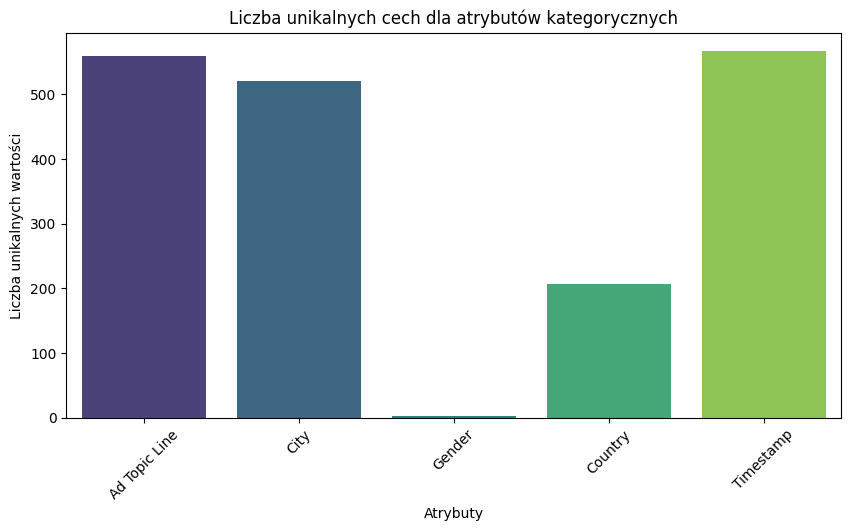

In [5]:
# wizualizacja wysokiej kardynalności cech
unique_counts_categorical = data_CTR.select_dtypes('object').nunique()

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_counts_categorical.index, y=unique_counts_categorical.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Atrybuty')
plt.ylabel('Liczba unikalnych wartości')
plt.title('Liczba unikalnych cech dla atrybutów kategorycznych')
plt.show()

In [6]:
# sprawdzenie brakujących wartości
data_CTR.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [7]:
# sprawdzenie wartości odstających
data_CTR.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,61.660757,35.940100,53840.047721,177.759831,0.491700
std,15.704142,8.572973,13343.708718,40.820951,0.499956
min,32.600000,19.000000,13996.500000,105.220000,0.000000
25%,48.860000,29.000000,44052.302500,140.150000,0.000000
50%,59.590000,35.000000,56180.930000,178.920000,0.000000
75%,76.580000,42.000000,61840.260000,212.670000,1.000000
max,90.970000,60.000000,79332.330000,269.960000,1.000000


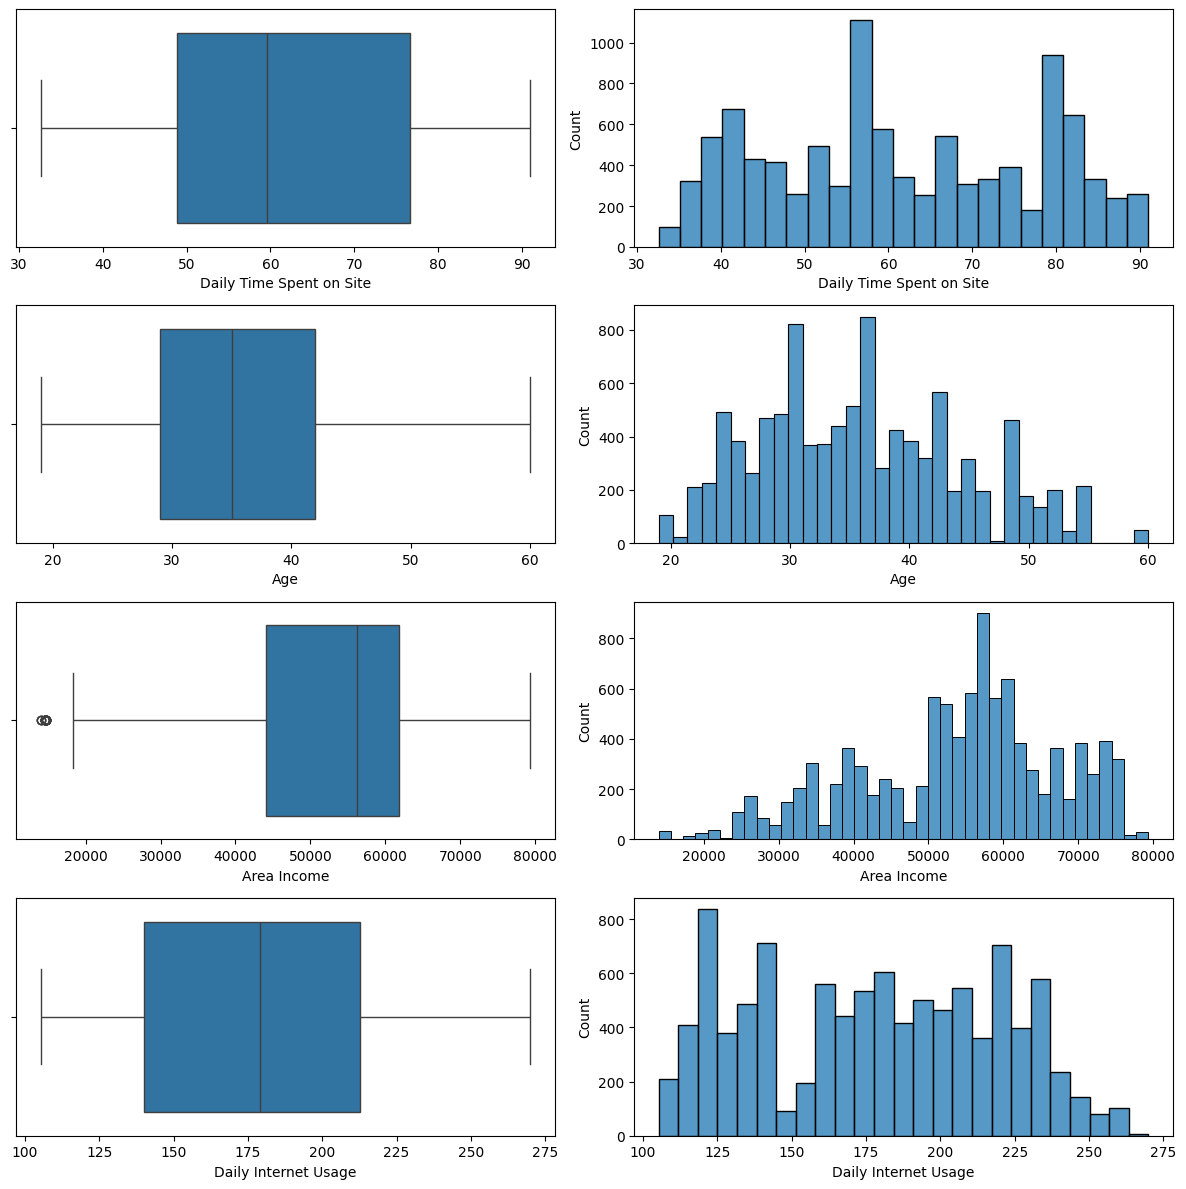

In [8]:
# sprawdzenie rozkładu kolumn numerycznych
columns_numeric = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

fig, axes = plt.subplots(nrows=len(columns_numeric), ncols=2, figsize=(12, len(columns_numeric) * 3))
for i, col in enumerate(columns_numeric):
    sns.boxplot(data=data_CTR, x=col, ax=axes[i, 0])   
    sns.histplot(data=data_CTR, x=col, ax=axes[i, 1])
plt.tight_layout()

<Axes: xlabel='Clicked on Ad', ylabel='count'>

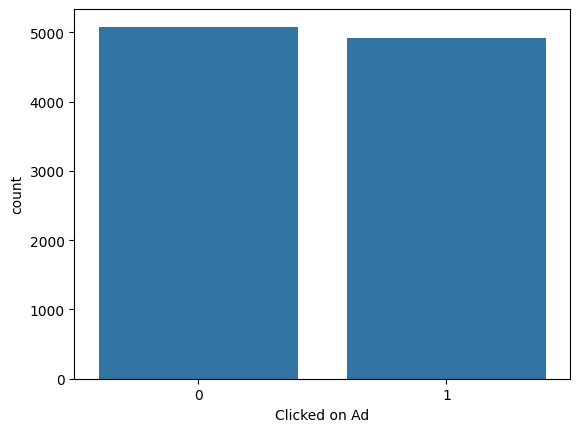

In [9]:
# zbadanie problemu niezbalansowania danych
sns.countplot(data= data_CTR, x= 'Clicked on Ad')

**Feature Hashing i Trenowanie Modelu**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction import FeatureHasher
import numpy as np

def model_training(data, feature_hash=True, target='Clicked on Ad', n_bits=8, visu= True, nrows= 10000):


    # ustalenie predyktora i cech
    y = data[:nrows][target]
    X = data[:nrows].drop([target], axis=1)
    
    # podział na zbiory: treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
        
    # trenowanie modelu bez wykorzystania metody Feature Hashing    
    model = LogisticRegression(max_iter=1000)  
    model.fit(X_train.select_dtypes('number'), y_train)

    # predykcja i ocena wyników bez FH
    y_pred = model.predict(X_test.select_dtypes('number'))

    if visu:
        print("Dokładność przed FH:", accuracy_score(y_test, y_pred))
        print("Miara F1 przed FH:", f1_score(y_test, y_pred), '\n')

        # macierz pomyłek
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot() 

    # trenowanie modelu z FH
    if feature_hash:

        # kolumny zawierające cechy kategoryczne
        categorical_features_train = X_train.select_dtypes('object').columns.tolist()
        categorical_features_test = X_test.select_dtypes('object').columns.tolist()
        
        # haszowanie cech kategorycznych
        hasher_train = FeatureHasher(n_features=2**n_bits, input_type='string')
        combined_features_train = X_train[categorical_features_train].apply(tuple, axis=1)
        hashed_features_train = hasher_train.fit_transform(combined_features_train).toarray()
        hashed_features_df_train = pd.DataFrame(hashed_features_train, columns=[f"hashed_feature_{i}" for i in range(hashed_features_train.shape[1])])
        
        hasher_test = FeatureHasher(n_features=2**n_bits, input_type='string')
        combined_features_test = X_test[categorical_features_test].apply(tuple, axis=1)
        hashed_features_test = hasher_test.transform(combined_features_test).toarray()
        hashed_features_df_test = pd.DataFrame(hashed_features_test, columns=[f"hashed_feature_{i}" for i in range(hashed_features_test.shape[1])])

        # łączenie cech numerycznych z cechami kategorycznymi po haszowaniu
        X_train_final = np.hstack([hashed_features_df_train, X_train.select_dtypes('number').values])
        X_test_final = np.hstack([hashed_features_df_test, X_test.select_dtypes('number').values])
        
        # trenowanie modelu z uwzględnieniem zakodowanych cech kategorycznych
        model = LogisticRegression(max_iter=1000)  
        model.fit(X_train_final, y_train)

        # predykcja i ocena
        y_pred = model.predict(X_test_final)

        if visu:
            print("Dokładność po FH:", accuracy_score(y_test, y_pred))
            print("Miara F1 po FH", f1_score(y_test, y_pred))

            # macierz pomyłek
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot() 

    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

Dokładność przed FH: 0.7076666666666667
Miara F1 przed FH: 0.6904341687257325 

Dokładność po FH: 0.826
Miara F1 po FH 0.8204951856946355


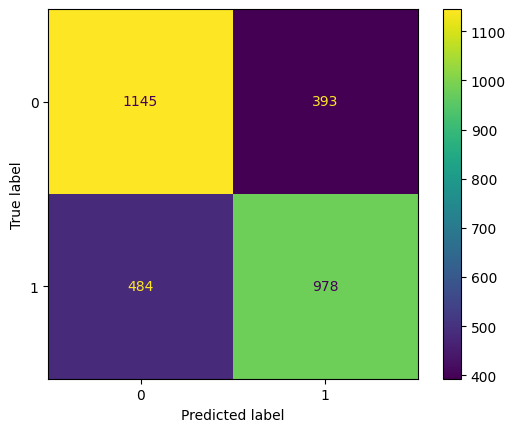

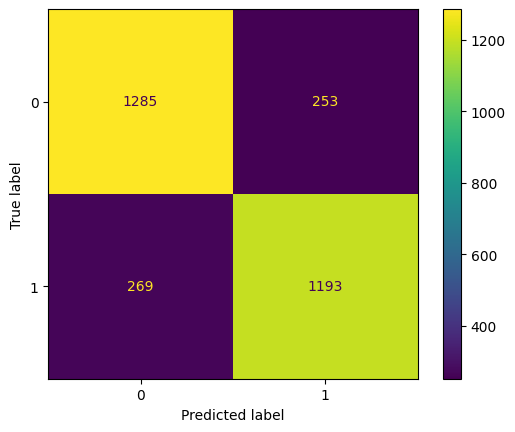

In [12]:
accuracy, f1 = model_training(data_CTR)

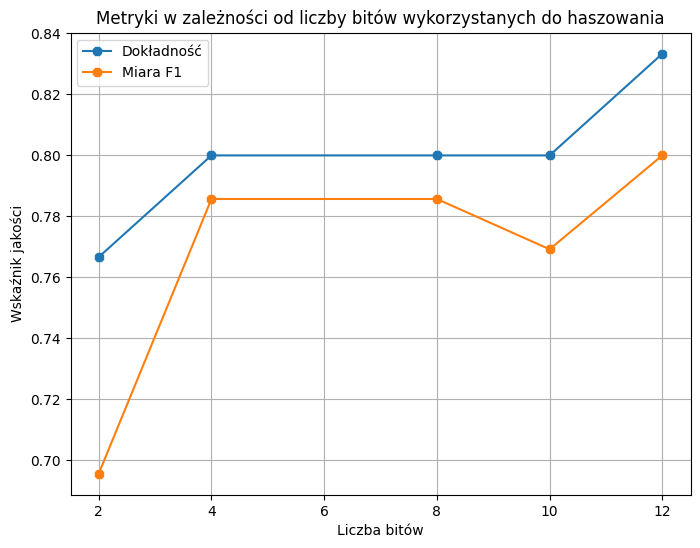

In [13]:
accuracies = []
f1s = []
bits = [2, 4, 8, 10, 12]
for n_bit in bits:
    accuracies.append(model_training(data_CTR, n_bits= n_bit, visu= False, nrows= 100)[0])
    f1s.append(model_training(data_CTR, n_bits= n_bit, visu= False, nrows= 100)[1])

_, ax1 = plt.subplots(figsize= (8, 6))
ax1.set_title('Metryki w zależności od liczby bitów wykorzystanych do haszowania')

ax1.plot(bits, accuracies, marker= '8', label= 'Dokładność')
ax1.plot(bits, f1s, marker= '8', label= 'Miara F1')
ax1.set_xlabel('Liczba bitów')
ax1.set_ylabel('Wskaźnik jakości')
ax1.legend()
ax1.grid(True)